# Data Analysis Indoor Location at University of Jaime I.
----------------------

## Library Importation

In [1]:
import sys
sys.path.append("./lib/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lib.Methods import GeneralMethods
from lib.edasSearch import EdasHyperparameterSearch
from lib.Hiperparametros import HyperparameterSwitcher
from lib.ImportacionModelos import getClassifierNames
from lib.ImportacionModelos import getClassifierModels
from lib.ImportacionModelos import getRegressorNames
from lib.ImportacionModelos import getRegressorModels
from lib.graphicGenerator import GraphicBuilder

description = pd.read_csv("data/description.csv", sep=";")
dfTrain = pd.read_csv("data/UJIndoorLoc_trainingData.csv")
dfTest = pd.read_csv("data/UJIndoorLoc_validationData.csv")
dfFull = dfTrain.append(dfTest, ignore_index=True)
gbFull = GraphicBuilder(dfFull)
# Setting new data type
dfFull.FLOOR = dfFull.FLOOR.apply(str)
dfFull.BUILDINGID = dfFull.BUILDINGID.apply(str)
dfFull.SPACEID = dfFull.SPACEID.apply(str)
dfFull.RELATIVEPOSITION = dfFull.RELATIVEPOSITION.apply(str)
dfFull.USERID = dfFull.USERID.apply(str)
dfFull.PHONEID = dfFull.PHONEID.apply(str)

## 1. Exploratory Analysis

In [2]:
display(description)
display(str(dfTrain.shape[1]) + ' features')
display('Train Shape: ' + str(dfTrain.shape[0]) + ' observations')
display('Test Shape:  ' + str(dfTest.shape[0]) + ' observations')

,Attribute,Definition
WAP001,Intensity value for WAP001,Negative integer values from -104 to 0 and +1...
...,...,...
WAP520,Intensity value for WAP520,Negative integer values from -104 to 0 and +1...
Longitude,Longitude,Negative real values from -7695.9387549299299...
Latitude,Latitude,Positive real values from 4864745.7450159714 ...
Floor,Altitude in floors inside the building,Integer values from 0 to 4.
BuildingID,ID to identify the building. Measures were ta...,Categorical integer values from 0 to 2.
SpaceID,Internal ID number to identify the Space (off...,Categorical integer values.
RelativePosition,Relative position with respect to the Space (...,Categorical integer values.
UserID,User identifier,Categorical integer values.


'529 features'

'Train Shape: 19937 observations'

'Test Shape:  1111 observations'

In [3]:
# Colums Data Description
display('Numerical Data')
display(dfFull[dfFull.columns.values[519:]].describe(include=['int64', 'float']))
display('Categorital Data')
display(dfFull[dfFull.columns.values[519:]].describe(include=['object']))

'Numerical Data'

,WAP520,LONGITUDE,LATITUDE,TIMESTAMP
count,21048.000000,21048.000000,2.104800e+04,2.104800e+04
mean,99.991733,-7467.702771,4.864873e+06,1.371906e+09
std,1.199344,124.084870,6.746981e+01,2.126924e+06
min,-74.000000,-7695.938755,4.864746e+06,1.369909e+09
25%,100.000000,-7601.616200,4.864821e+06,1.371709e+09
50%,100.000000,-7425.661100,4.864854e+06,1.371716e+09
75%,100.000000,-7359.331100,4.864930e+06,1.371721e+09
max,100.000000,-7299.786517,4.865017e+06,1.381248e+09


'Categorital Data'

,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID
count,21048,21048,21048,21048,21048,21048
unique,5,3,124,3,19,25
top,1,2,0,2,11,13
freq,5464,9760,1111,16608,4516,4885


FLOOR,0,1,2,3,4
BUILDINGID,,,,,
0,1137,1564,1608,1476,0
1,1398,1627,1483,995,0
2,1966,2273,1631,2749,1141


<IPython.core.display.Javascript object>


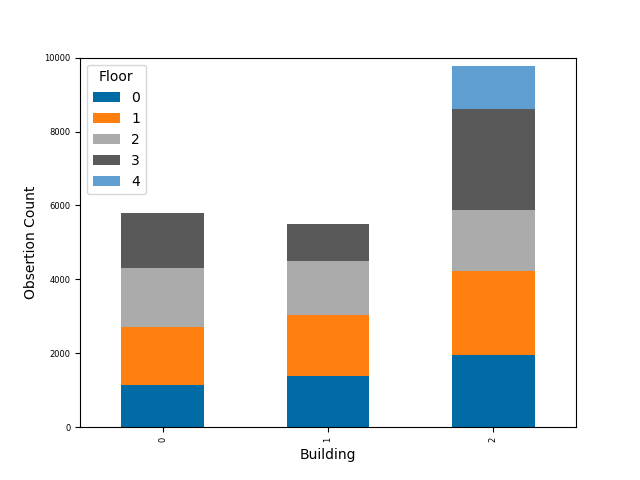

In [4]:
#sns.barplot(x=dfTrain.period, y=dfTrain.value, hue=stacked.mark)
%matplotlib notebook
fullct = pd.crosstab(dfFull.BUILDINGID, dfFull.FLOOR)
display(fullct)
ax = fullct.plot.bar(stacked=True)
ax.set_xlabel("Building")
ax.set_ylabel("Obsertion Count")
#ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 10000)
plt.legend(title='Floor')
plt.show()

<IPython.core.display.Javascript object>


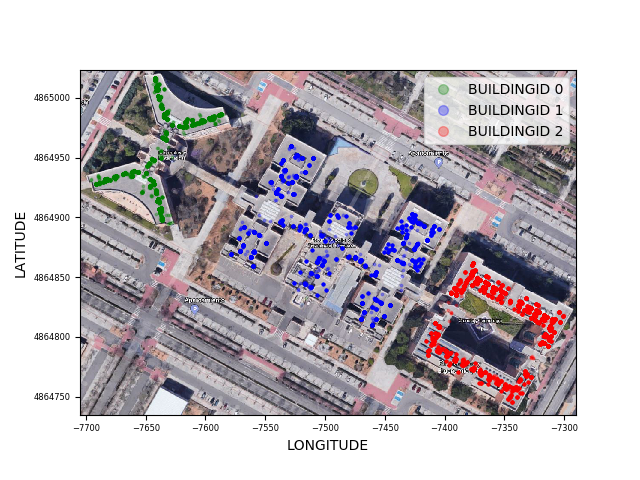

In [16]:
gbFull.graphicMap2D(filename="buildingsMap2d", x="LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


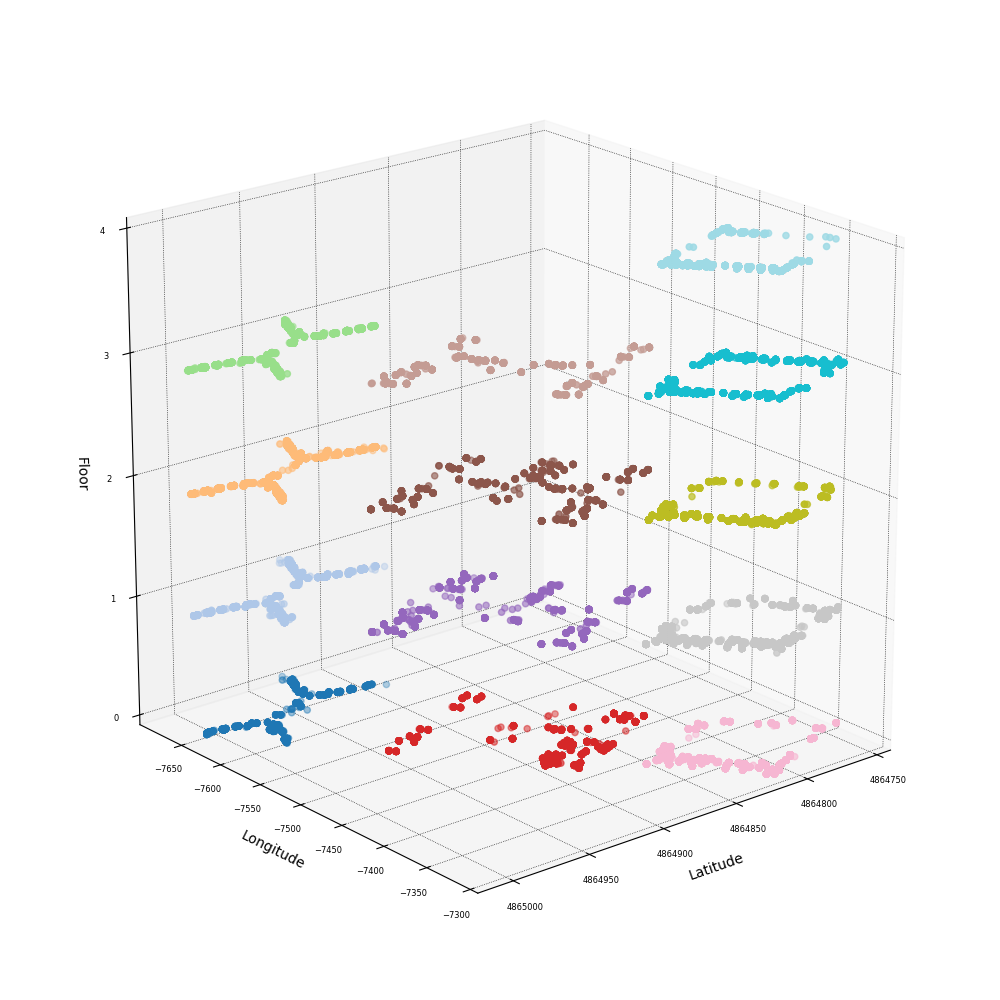

In [19]:
#gbFull.graphicBuildings(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsTrain")
gbFull.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3d")

## 2. Data Cleaning and Feature Engineering

$WAP\in (-104,0)$, $WAP=100$ when WAP is not detected. 

Infering that $WAP \in [-120,0]$ and set $WAP=-120$ when is not detected

Parsing WAP to range $[0,1]$ where 0 is not detected and 1 is ideal signal

Having $-120<=WAP<=0$, set rssi transformation to  $0<=\frac{WAP+120}{120}<=1$

### Dealing with missing data

In [5]:
wifiSens = 520
rssiLimit = 120
wifiColumns = dfFull.columns.values[:wifiSens]
outColumns = dfFull.columns.values[wifiSens:]
x_data = dfFull[wifiColumns]
x_data.replace([100],[-rssiLimit], inplace=True)
x_data = x_data.apply(lambda x: (x+rssiLimit)/rssiLimit, axis=1)
ndwapDf = list(map(lambda wapName: pd.DataFrame(list(map(lambda x: {'ND_' + wapName:x==0}, x_data[wapName]))), wifiColumns))
dfFiltered = pd.concat([x_data] + ndwapDf, axis=1)
dfFiltered[dfFiltered.columns.values[wifiSens:]] = dfFiltered[dfFiltered.columns.values[wifiSens:]].astype(int)
dfFiltered['ND_WAP_COUNT'] = dfFiltered[dfFiltered.columns.values[wifiSens:]].sum(axis=1) # wap no detecteds
dfClean = pd.concat([dfFiltered, dfFull[outColumns]], axis=1)

### Dealing with unwanted observations

__Duplicated Data:__ Drop all rows whose column values are the same, conserve first apparition

In [6]:
dfClean[dfClean.duplicated(dfClean.columns.values, keep='first')].shape

(637, 1050)

In [7]:
display('Initial Size:' + str(dfClean.shape))
dfClean.drop_duplicates(dfClean.columns.values, keep='first', inplace=True)
dfClean.reset_index(drop=True, inplace=True)
display('Final Size:' + str(dfClean.shape))

'Size Inicial:(21048, 1050)'

'Size Final:(20411, 1050)'

__Irrelevant observations:__ Two study cases that could reduce the consistency of the data

__Case 1:__ What happen if all wap are not detected?

In [10]:
dfWap = dfClean[wifiColumns]
#dfNoDetectedWap = dfClean[dfWap.sum(axis=1) == 0] #suma de columnas
dfNoDetectedWap = dfClean[dfClean.ND_WAP_COUNT == wifiSens] #suma de columnas
gbNDWap = GraphicBuilder(dfNoDetectedWap)
dfNoDetectedWap.shape

(73, 1050)

FLOOR,0,1,2,3
BUILDINGID,,,,
0,1,0,0,0
1,0,0,0,34
2,36,1,1,0


<IPython.core.display.Javascript object>


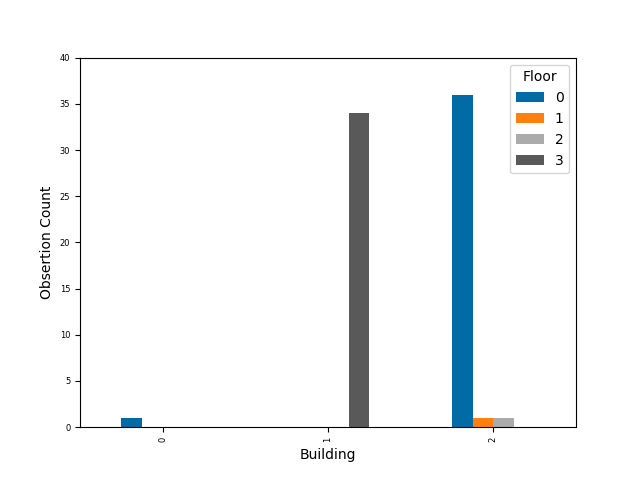

In [11]:
fullct1 = pd.crosstab(dfNoDetectedWap.BUILDINGID, dfNoDetectedWap.FLOOR)
display(fullct1)
#"""
ax = fullct1.plot.bar(stacked=False)
ax.set_xlabel("Building")
ax.set_ylabel("Obsertion Count")
#ax.set_xlim(xmin, xmax)
ax.set_ylim(0, 40)
plt.legend(title='Floor')
plt.show()
#"""
#gbNDWap.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3dNotDetected")

_These data would be relevant if we had at least one signal that made us distinguish between buildings, or if we work the buildings separately. But as it is not the case these data only generate inconsistency and randomness._

In [ ]:
display('Initial Size:' + str(dfClean.shape))
dfClean = dfClean[dfClean.ND_WAP_COUNT != wifiSens]
dfClean.reset_index(drop=True, inplace=True)
display('Final Size:' + str(dfClean.shape))

__Case 2:__ What happen if for some wap is never detected?

In [31]:
display('Max observations with not detected wap: ' + str(np.max(dfClean[dfClean.columns.values[wifiSens:2*wifiSens]].sum(axis=0))))
display('Max observations: ' + str(dfClean.shape[0]))

'Max observations with not detected wap: 20337'

'Max observations: 20338'

_Case 2 is not happening in CleanData_

## 4. Algorithm Selection

In [35]:
from sklearn.model_selection import train_test_split
seed = 7
X = dfClean[dfClean.columns.values[:2*wifiSens+1]]
Y = dfClean[dfClean.columns.values[2*wifiSens+1:2*wifiSens+5]]

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID
0,-7541.264300,4.864921e+06,2,1
1,-7536.621200,4.864934e+06,2,1
2,-7519.152400,4.864950e+06,2,1
3,-7524.570400,4.864934e+06,2,1
4,-7533.896200,4.864939e+06,2,1
5,-7519.152400,4.864950e+06,2,1
6,-7527.451100,4.864929e+06,2,1
7,-7559.497300,4.864888e+06,2,1
8,-7510.437173,4.864949e+06,2,1
9,-7528.816402,4.864959e+06,2,1


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
gbTrain = GraphicBuilder(pd.concat([X_train, y_train],axis=1))
gbTest = GraphicBuilder(pd.concat([X_test, y_test],axis=1))

<IPython.core.display.Javascript object>


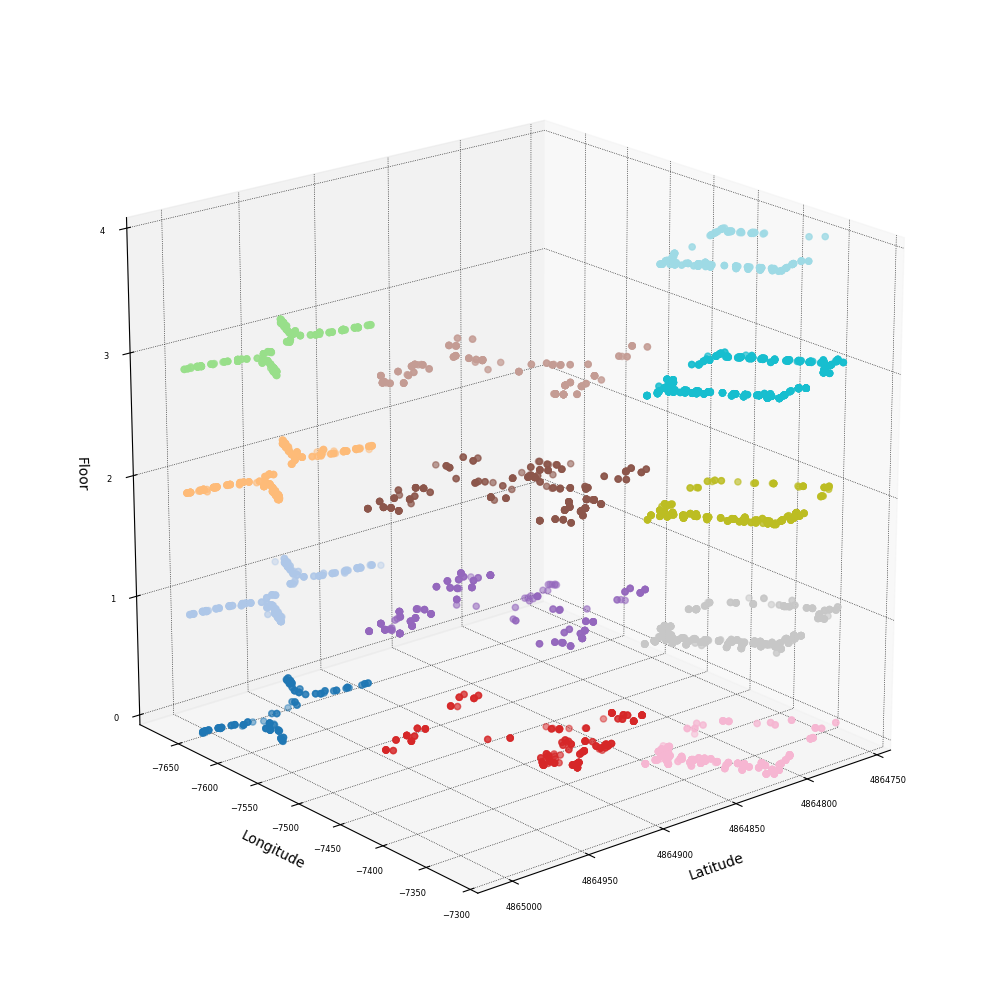

In [41]:
gbTest.graphicMap3D(columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="buildingsMap3dTest")

## 5. Model Training

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
modelClassifier = RandomForestClassifier(n_jobs=-1, random_state=seed)
modelRegressor = RandomForestRegressor(n_jobs=-1, random_state=seed)

scoring ='accuracy'
scoreFloor = cross_validate(modelClassifier, X_train, y_train.FLOOR, scoring=scoring, cv=kf, return_train_score=False)
scoreBuilding = cross_validate(modelClassifier, X_train, y_train.BUILDINGID, scoring=scoring, cv=kf, return_train_score=False)

scoring ='r2'
scoreLatitude = cross_validate(modelRegressor, X_train, y_train.LATITUDE, scoring=scoring, cv=kf, return_train_score=False)
scoreLongitude = cross_validate(modelRegressor, X_train, y_train.LONGITUDE, scoring=scoring, cv=kf, return_train_score=False)

In [52]:
""" Sin Filtrar
'Floor Classification Score'

0.8046804680468047

'Building Classification Score'

0.9981998199819982

'Latitude Regression Score'

0.9626092899099439

'Longitude Regression Score'

0.9833886078390593
#"""
display(scoreFloor['test_score'].mean())
display(scoreBuilding['test_score'].mean())
display(scoreLatitude['test_score'].mean())
display(scoreLongitude['test_score'].mean())

0.9886293792255685

0.9998770743700062

0.9949990007518199

0.9975644650801835

In [56]:
modelClassifier.fit(X_train, y_train.FLOOR)
#p_floor = modelClassifier.predict(X_test)
display('Floor Classification Score')
display(modelClassifier.score(X_test, y_test.FLOOR))

modelClassifier.fit(X_train, y_train.BUILDINGID)
#p_building = model.predict(X_test)
display('Building Classification Score')
display(modelClassifier.score(X_test, y_test.BUILDINGID))
"""
modelRegressor.fit(X_train, y_test.LATITUDE)
#p_latitude = model.predict(xTest)
display('Latitude Regression Score')
display(modelRegressor.score(X_test, y_test.LATITUDE))

modelRegressor.fit(X_train, y_test.LONGITUDE)
#p_longitude = model.predict(xTest)
display('Longitude Regression Score')
display(modelRegressor.score(X_test, y_test.LONGITUDE))
"""

'Floor Classification Score'

0.9931170108161259

'Building Classification Score'

0.9997541789577188

"\nmodelRegressor.fit(X_train, y_test.LATITUDE)\n#p_latitude = model.predict(xTest)\ndisplay('Latitude Regression Score')\ndisplay(modelRegressor.score(X_test, y_test.LATITUDE))\n\nmodelRegressor.fit(X_train, y_test.LONGITUDE)\n#p_longitude = model.predict(xTest)\ndisplay('Longitude Regression Score')\ndisplay(modelRegressor.score(X_test, y_test.LONGITUDE))\n"

In [13]:
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

#seed = 7
#wifiSens = 520
xTrain = dfTrain[dfTrain.columns.values[0:wifiSens]]
# xTrain = dfTrain #[list(wa_columns)]
xTest = dfTest[dfTest.columns.values[0:wifiSens]]
#xTest = dfTest #[list(wa_columns)]

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.FLOOR)
p_floor = model.predict(xTest)
display('Floor Classification Score')
display(model.score(xTest, dfTest.FLOOR))

model = RandomForestClassifier(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.BUILDINGID)
p_building = model.predict(xTest)
display('Building Classification Score')
display(model.score(xTest, dfTest.BUILDINGID))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LATITUDE)
p_latitude = model.predict(xTest)
display('Latitude Regression Score')
display(model.score(xTest, dfTest.LATITUDE))

model = RandomForestRegressor(n_jobs=-1, random_state=seed)
model.fit(xTrain, dfTrain.LONGITUDE)
p_longitude = model.predict(xTest)
display('Longitude Regression Score')
display(model.score(xTest, dfTest.LONGITUDE))

# setting predicted values into dataframe
dfTest['PRED_FLOOR'] = p_floor
dfTest['PRED_BUILDING'] = p_building
dfTest['PRED_LATITUDE'] = p_latitude
dfTest['PRED_LONGITUDE'] = p_longitude
"""


'Floor Classification Score'

0.8046804680468047

'Building Classification Score'

0.9981998199819982

'Latitude Regression Score'

0.9626092899099439

'Longitude Regression Score'

0.9833886078390593

## 6. Model Tunning

### Eas Search

### Edas Search

### Randomized Search

### Grid Search

## 7. Model Comparison

## 8. Evaluation Result & Error

<IPython.core.display.Javascript object>


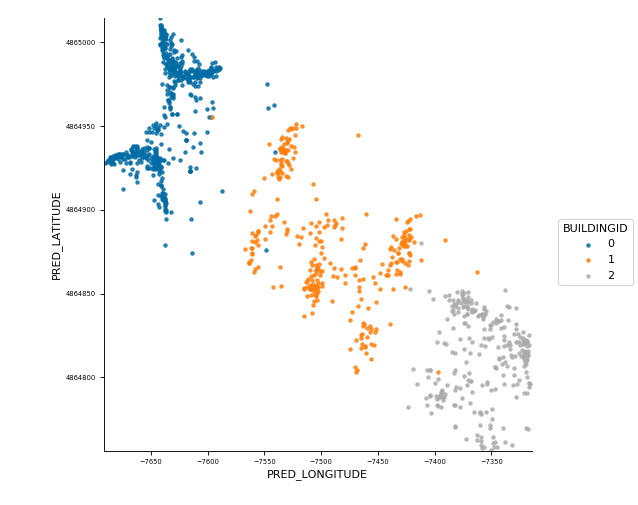

In [17]:
graphicMap2D(dfTest, filename="predicted2d", x = "PRED_LONGITUDE", y="PRED_LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


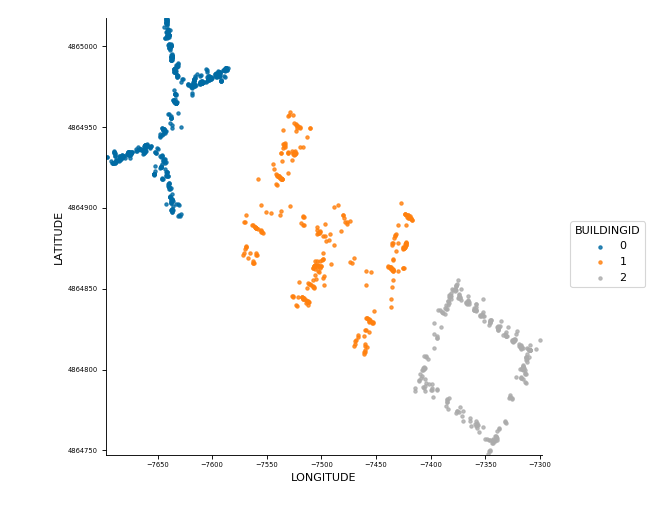

In [16]:
graphicMap2D(dfTest, filename="validated2d", x = "LONGITUDE", y="LATITUDE", hue="BUILDINGID")

<IPython.core.display.Javascript object>


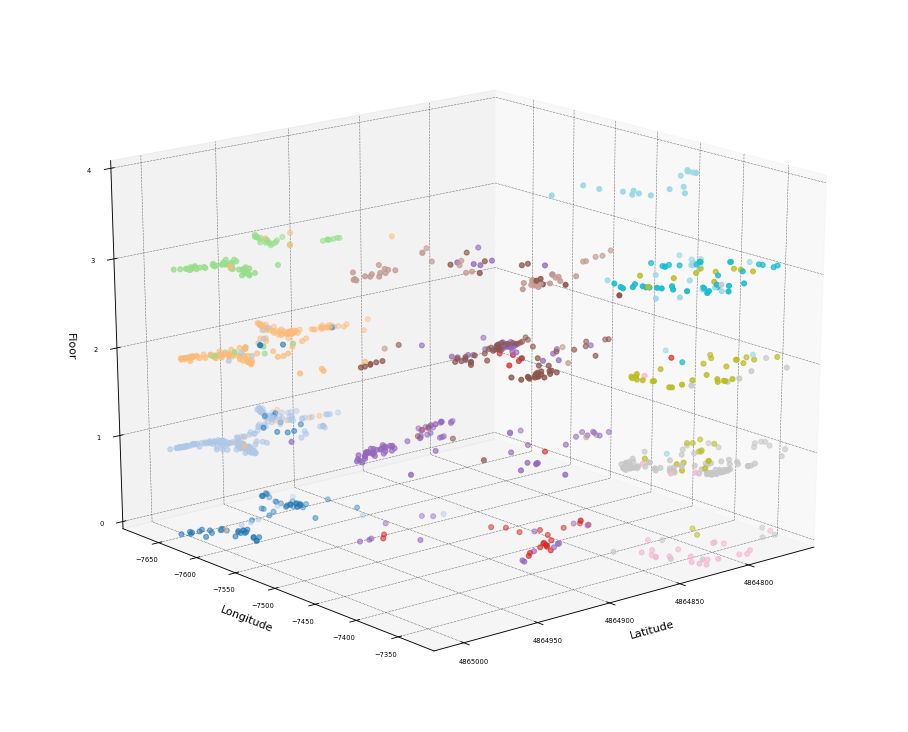

In [18]:
graphicMap3D(dfTest, columns = ["PRED_LATITUDE", "PRED_LONGITUDE", "PRED_FLOOR"], filename="predictedBuildingsMap3d")

<IPython.core.display.Javascript object>


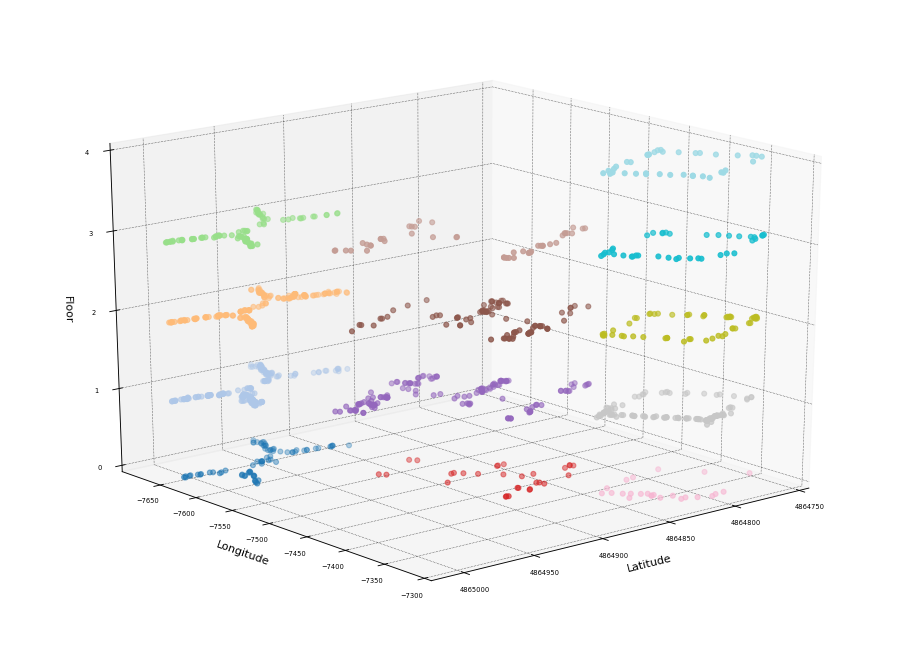

In [19]:
graphicMap3D(dfTest, columns = ["LATITUDE", "LONGITUDE", "FLOOR"], filename="realBuildingsMap3d")